교차상관계수 (Cross-Correlation)	시차상관계수 (Lagged Correlation)

## 1. 교차상관계수

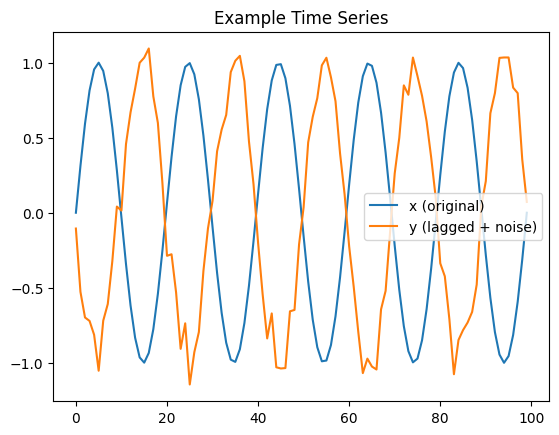

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 시계열 생성: X는 정사인파, Y는 시차가 있는 X
np.random.seed(0)
n = 100
x = np.sin(np.linspace(0, 10*np.pi, n))
y = np.roll(x, 10) + np.random.normal(0, 0.1, n)  # x를 오른쪽으로 10칸 이동 + 노이즈 추가

plt.plot(x, label='x (original)')
plt.plot(y, label='y (lagged + noise)')
plt.legend()
plt.title('Example Time Series')
plt.show()


시차 상관계수 계산 함수

In [2]:
from scipy.signal import correlate
from scipy.stats import zscore

def cross_correlation(x, y, max_lag):
    x = zscore(x)
    y = zscore(y)
    corr = correlate(y, x, mode='full') / len(x)
    lags = np.arange(-len(x) + 1, len(x))
    center = len(corr) // 2
    corr = corr[center - max_lag:center + max_lag + 1]
    lags = lags[center - max_lag:center + max_lag + 1]
    return lags, corr


시차 상관계수 계산 및 시각화

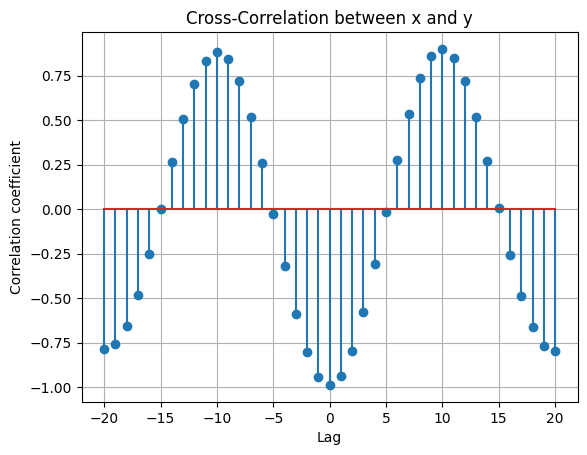

최대 상관 시차: 10


In [6]:
max_lag = 20
lags, corr = cross_correlation(x, y, max_lag)

plt.stem(lags, corr)  # ✅ plt 로 수정!
plt.title('Cross-Correlation between x and y')
plt.xlabel('Lag')
plt.ylabel('Correlation coefficient')
plt.grid()
plt.show()

print("최대 상관 시차:", lags[np.argmax(corr)])


## 2. 삼성전자와 sk하이닉스 주가데이터

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


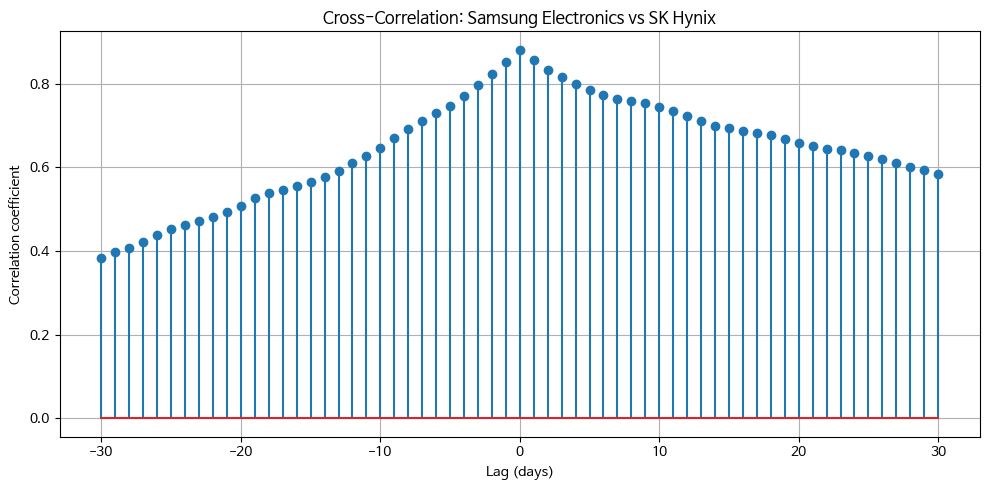

(0, 0.8814856493569149)

In [7]:
from datetime import datetime
from pykrx import stock
import pandas as pd
import numpy as np
from scipy.signal import correlate
from scipy.stats import zscore
import matplotlib.pyplot as plt

# 1. 날짜 범위 설정
start_date = "2023-01-01"
end_date = "2023-12-31"

# 2. 삼성전자와 SK하이닉스 일별 종가 가져오기
df_samsung = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")["종가"]
df_sk = stock.get_market_ohlcv_by_date(start_date, end_date, "000660")["종가"]

# 3. 날짜 기준 병합 (공통 일자만 사용)
df = pd.concat([df_samsung, df_sk], axis=1, join="inner")
df.columns = ["Samsung", "SK_Hynix"]

# 4. 결측값 제거
df = df.dropna()

# 5. Z-score 정규화
x = zscore(df["Samsung"].values)
y = zscore(df["SK_Hynix"].values)

# 6. 교차상관계수 계산 함수
def cross_correlation(x, y, max_lag):
    corr = correlate(y, x, mode='full') / len(x)
    lags = np.arange(-len(x) + 1, len(x))
    center = len(corr) // 2
    corr = corr[center - max_lag:center + max_lag + 1]
    lags = lags[center - max_lag:center + max_lag + 1]
    return lags, corr

# 7. 계산
max_lag = 30
lags, corr = cross_correlation(x, y, max_lag)

# 8. 결과 시각화
plt.figure(figsize=(10, 5))
plt.stem(lags, corr)
plt.title("Cross-Correlation: Samsung Electronics vs SK Hynix")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

# 최대 상관 시차
max_corr_lag = lags[np.argmax(corr)]
max_corr_value = np.max(corr)

max_corr_lag, max_corr_value


In [ ]:
# Lag = 0: 동시 상관도

# 양의 Lag: 삼성전자가 먼저 변동 → 이후 SK하이닉스 반응

# 음의 Lag: SK하이닉스가 먼저 변동 → 이후 삼성전자 반응

## 3. 시차상관계수 (Auto Cross-Correlation) 

### 3-1 삼성전자 (수익률(Return)"로 변환하여 삼성전자 종가의 자기상관(시차상관) 분석

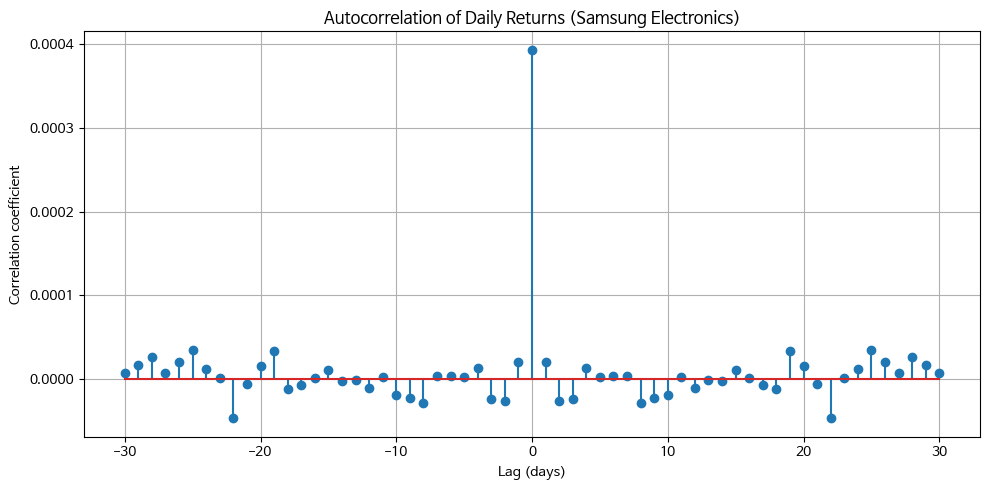

최대 자기상관 시차: 0 일


In [10]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# 1. 데이터 가져오기
start = "2024-01-01"
end = "2025-06-30"
price = stock.get_market_ohlcv_by_date(start, end, "005930")["종가"]

# 2. 수익률 계산 (일간 수익률)
returns = price.pct_change().dropna()

# 3. 시차 상관계수 함수 정의
def cross_correlation(x, y, max_lag):
    corr = correlate(y, x, mode='full') / len(x)
    lags = np.arange(-len(x) + 1, len(x))
    center = len(corr) // 2
    corr = corr[center - max_lag:center + max_lag + 1]
    lags = lags[center - max_lag:center + max_lag + 1]
    return lags, corr

# 4. 자기 자신과의 시차 상관계수 계산
x = returns.values
lags, corr = cross_correlation(x, x, max_lag=30)

# 5. 시각화
plt.figure(figsize=(10, 5))
plt.stem(lags, corr)
plt.title("Autocorrelation of Daily Returns (Samsung Electronics)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. 결과 출력
max_corr_lag = lags[np.argmax(corr)]
print("최대 자기상관 시차:", max_corr_lag, "일")


In [ ]:
# lag = 0에서 자기상관계수가 1이 아닌가?
# 이론적으로, 자기자신과의 상관계수 (lag = 0) 는 항상 1이어야 합니다.
# 그러나 scipy.signal.correlate()를 이용한 직접 계산 방식에서는 다음 두 가지 이유 때문에 lag=0이 정확히 1이 되지 않을 수 있습니다:

# 이유 1: 정규화(Normalization) 누락
# correlate() 함수는 단순한 cross-correlation을 수행하며, 표준화(standardization) 또는 코사인 정규화를 자동으로 적용하지 않습니다.
# 즉, 분산(variance) 으로 나누지 않기 때문에 결과가 상관계수가 아닐 수 있습니다.

# 해결 방법: np.corrcoef() 또는 수동 정규화를 해줘야 합니다.

# 이유 2: 수익률 데이터의 평균이 0이 아님
# 상관계수를 계산할 때는 평균을 제거해야 합니다. correlate()는 이 처리를 하지 않습니다. 따라서 평균이 0이 아닌 시계열을 곧바로 넣으면 lag=0에서 1이 안 나옵니다.



### 3-2  정규화 후

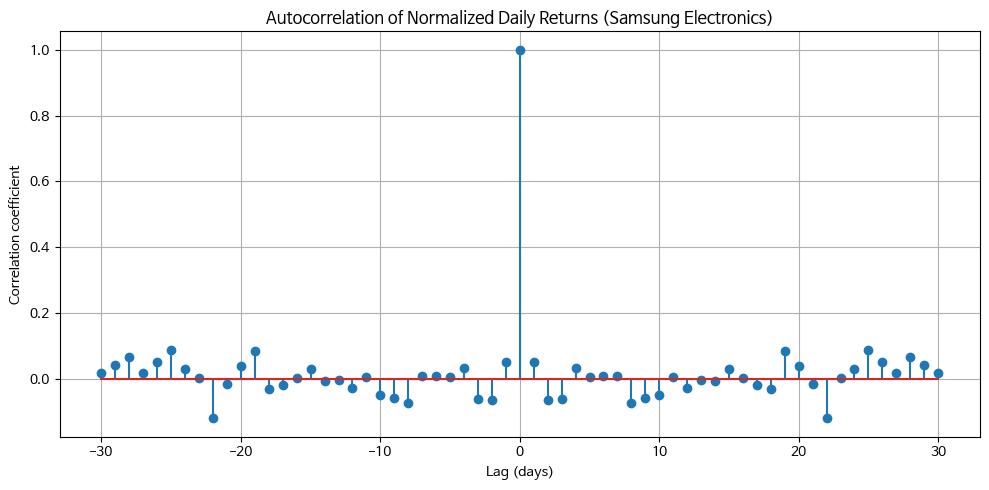

lag = 0 에서 상관계수: 0.9999999999999999
최대 자기상관 시차: 0 일


In [11]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# 1. 데이터 가져오기
start = "2024-01-01"
end = "2025-06-30"
price = stock.get_market_ohlcv_by_date(start, end, "005930")["종가"]

# 2. 수익률 계산 (일간 수익률)
returns = price.pct_change().dropna()

# 3. 평균 0, 표준편차 1로 정규화
x = returns.values
x = (x - np.mean(x)) / np.std(x)

# 4. 시차 상관계수 계산 함수
def cross_correlation(x, y, max_lag):
    corr = correlate(y, x, mode='full') / len(x)
    lags = np.arange(-len(x) + 1, len(x))
    center = len(corr) // 2
    corr = corr[center - max_lag:center + max_lag + 1]
    lags = lags[center - max_lag:center + max_lag + 1]
    return lags, corr

# 5. 자기 자신과의 시차 상관계수 계산
lags, corr = cross_correlation(x, x, max_lag=30)

# 6. 시각화
plt.figure(figsize=(10, 5))
plt.stem(lags, corr)
plt.title("Autocorrelation of Normalized Daily Returns (Samsung Electronics)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 결과 출력
print("lag = 0 에서 상관계수:", corr[30])  # lag=0은 center
print("최대 자기상관 시차:", lags[np.argmax(corr)], "일")


### 3-2 Z-score 정규화

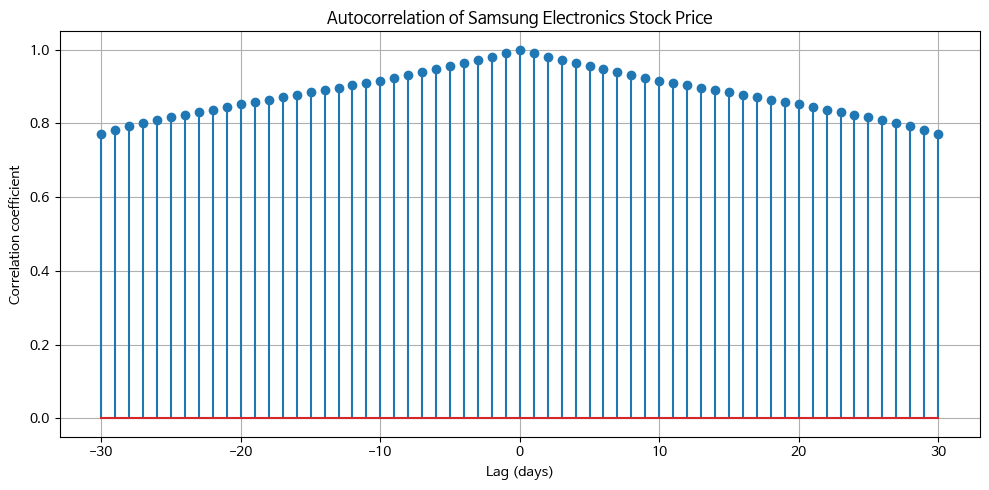

최대 자기상관 시차: 0 일


In [8]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import zscore

# 1. 주가 데이터 가져오기
start = "2024-01-01"
end = "2025-06-30"

price = stock.get_market_ohlcv_by_date(start, end, "005930")["종가"]

# 2. 결측치 제거
price = price.dropna()

# 3. Z-score 정규화
x = zscore(price.values)

# 4. 시차 상관계수 계산 함수
def cross_correlation(x, y, max_lag):
    corr = correlate(y, x, mode='full') / len(x)
    lags = np.arange(-len(x) + 1, len(x))
    center = len(corr) // 2
    corr = corr[center - max_lag:center + max_lag + 1]
    lags = lags[center - max_lag:center + max_lag + 1]
    return lags, corr

# 5. 자기 자신에 대한 시차 상관계수
lags, corr = cross_correlation(x, x, max_lag=30)

# 6. 시각화
plt.figure(figsize=(10, 5))
plt.stem(lags, corr)
plt.title("Autocorrelation of Samsung Electronics Stock Price")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 최대값 위치
max_corr_lag = lags[np.argmax(corr)]
print("최대 자기상관 시차:", max_corr_lag, "일")
